# Computing planet fluxes


The photometry package contains a class to compute the flux of the planets that are used as primary calibrators in (sub-)mm astronomy. For the gas giants Uranus and Neptune, the class use the ESA models by Moreno et al. for the brightness temperature, and relies on the JPL Horizons for the ephemeris. This notebook illustrate how to predict the flux of a planet.

In [1]:
%matplotlib inline
import photometry as pt
from astropy import units as u
from astropy.coordinates import Angle
import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time

In [2]:
# initialize the planets
uranus = pt.GiantPlanet('Uranus')
neptune = pt.GiantPlanet('Neptune')

In [3]:
# compute neptune solid angle for one date, and uranus for two
neptune.set_dates(Time('2017-04-20T00:00:00.0'))
neptune_omega = neptune.solid_angle()
uranus.set_dates(Time(['2015-10-15T00:00:00.0','2017-04-20T00:00:00.0']))
uranus_omega =  uranus.solid_angle()

In [4]:
print("neptune solid angle: {}".format(neptune_omega))
print("uranus solid angle: {}".format(uranus_omega))

neptune solid angle: 9.044672375164236e-11 rad2
uranus solid angle: [  2.49967181e-10   2.06228857e-10] rad2


In [5]:
spec_uranus = uranus.spectral_irradiance()
spec_neptune_2017 = neptune.spectral_irradiance()

In [6]:
nika2mm = pt.Passband(file='2mm.NIKA2.pb')
nika1mmH = pt.Passband(file='1mmH.NIKA2.pb')
nika1mmV = pt.Passband(file='1mmV.NIKA2.pb')

Here we will use the fnu_ab() method to compute the planet fluxes. Basically AB convention quote the flux that a source that was generating the same response as our objcet would have with a spectrum $S^0_\nu$=cte. 

$\int T_{\nu} S^0_{\nu} d\nu = \int S_{\nu} T_{\nu} d\nu$

Where $T_{\nu}$ is the system response. 

So that:

$  S^0_{\nu} = \frac{\int S_{\nu} T_{\nu} d\nu}{\int T_{\nu} d\nu}$



In [7]:
nika2mm.fnu_ab?

In [8]:
print("Uranus fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika2mm.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika1mmV.fnu_ab(spec_uranus).to(u.Jy)[1]))
# Recall that 2017 is the second spectrum..

Uranus fluxes in 2017:
1mmH: 36.752 Jy | 2mm: 15.002 Jy | 1mmV: 37.389 Jy


In [9]:
# Print all the uranus fluxes
nika2mm.fnu_ab(spec_uranus).to(u.Jy)

<Quantity [ 18.18408287, 15.00229995] Jy>

In [10]:
print("Neptune fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))


Neptune fluxes in 2017:
1mmH: 15.672 Jy | 2mm: 6.858 Jy | 1mmV: 15.931 Jy


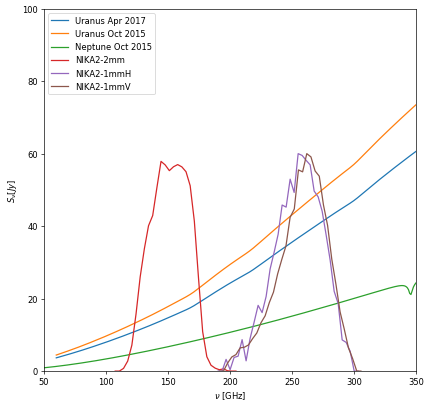

In [11]:
fig1 = plt.figure(1, (8,8), 60)
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[1,:], label='Uranus Apr 2017')
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[0,:], label='Uranus Oct 2015')
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Neptune Oct 2015')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.axis([50, 350, 0, 100])
plt.plot(nika2mm.nu(u.GHz), nika2mm.y*60., label='NIKA2-2mm')
plt.plot(nika1mmH.nu(u.GHz), nika1mmH.y*60., label='NIKA2-1mmH')
plt.plot(nika1mmV.nu(u.GHz), nika1mmV.y*60., label='NIKA2-1mmV')
plt.legend(loc='upper left', frameon=True)





In NIKA, the NIKA2 predecessor, a different convention for quoting fluxes was used:

$ S_{\nu_{0}}= S_{\nu_{0}}^{c} \frac{\int S_{\nu} T_{\nu} d \nu }{\int S_{\nu}^{c} T_{\nu} d \nu} $

Where $S_{\nu}$ is the spectrum of the object, and $S_{\nu}^{c}$ is the spectrum of the calibrator, and $\nu_{0}$ is the reference frequency of the band. In other word, the quoted flux is the the flux that the would planet have at the reference frequency $\nu_{0}$ in order to generate the same response from the instrument as the object.

So the flux used for the planet are the one at the reference frequency. Here is how to obtain them:

In [12]:
print(nika1mmH.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmH.xref(u.GHz)).to(u.Jy))

260.0 GHz
[ 45.96135186  37.91920614] Jy


In [13]:
print(nika1mmV.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmV.xref(u.GHz)).to(u.Jy))

260.0 GHz
[ 45.96135186  37.91920614] Jy


In [14]:
print(nika2mm.xref(u.GHz))
print(spec_uranus.fnu_nu(nika2mm.xref(u.GHz)).to(u.Jy))

150.0 GHz
[ 17.79495937  14.68126382] Jy


Since both the 1mmH and 1mmV have the same reference frequency, the planet flux is the same for both. This is why the convention adopted was changed. An other possibility would have to have to different reference frequencies for the two bands, acknowledging that they are different. Their difference though is not that large: when taking into account the atmosphere, passband change with elevation as can be seen in the irampassband_howto notebook.